# 📊 Entraînement du modèle optimal

Ce notebook charge automatiquement les meilleurs hyperparamètres depuis un fichier CSV (`resultats_grid_search.csv`) et entraîne le modèle correspondant sur les données d'accéléromètre/gyroscope.

In [1]:
#  Imports
import pandas as pd
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import joblib
import os
from google.colab import files

##  Chargement des meilleurs paramètres

In [3]:
#  Uploader le fichier de résultats si nécessaire
from google.colab import files
uploaded = files.upload()


Saving resultats_grid_search.csv to resultats_grid_search.csv


In [4]:
#  Lire le fichier CSV de résultats
resultats = pd.read_csv("resultats_grid_search.csv")
meilleur = resultats[resultats["metric"] == "precision_macro"].sort_values(by="mean_score", ascending=False).iloc[0]

#  Extraire les paramètres
cutoff = meilleur["cutoff"]
window = meilleur["window"]
with_freqs = meilleur["with_freqs"]
stride = meilleur["stride"]
model_type = meilleur["model"]

print("✅ Configuration optimale sélectionnée :")
print(meilleur)

✅ Configuration optimale sélectionnée :
cutoff                     20
window                    150
with_freqs               True
stride                     75
model                     SVM
metric        precision_macro
mean_score           0.997872
std_score            0.004255
Name: 0, dtype: object


## ⚙️ Fonctions de traitement du signal et d'extraction de features

In [5]:
#  Filtrage passe-bas
def lowpass_filter(signal, cutoff, fs):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(4, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

#  Extraction des features
def extraire_features(df, label, fs=71.4):
    features = {}
    for axe in ['accel.x', 'accel.y', 'accel.z', 'gyro.x', 'gyro.y', 'gyro.z']:
        signal = df[axe].values
        signal = lowpass_filter(signal, cutoff, fs)
        features[f'{axe}_mean'] = np.mean(signal)
        features[f'{axe}_std'] = np.std(signal)
        features[f'{axe}_min'] = np.min(signal)
        features[f'{axe}_max'] = np.max(signal)
        features[f'{axe}_energy'] = np.sum(signal**2)

        if with_freqs:
            yf = fft(signal)
            xf = fftfreq(len(signal), 1/fs)
            freqs = xf[:len(signal)//2]
            mags = np.abs(yf[:len(signal)//2])
            dom_freq = freqs[np.argmax(mags)]
            features[f'{axe}_dom_freq'] = dom_freq

    features['label'] = label
    return features

##  Chargement des fichiers de données capteurs

In [6]:
uploaded = files.upload()

# 📂 Identifier les bons fichiers CSV
fichiers = [(f, "frisson" if "frisson" in f.lower() else "repos") for f in os.listdir() if f.endswith(".csv") and "features" not in f and f != "meilleurs_resultats.csv"]

Saving repos_rotation.csv to repos_rotation.csv
Saving repos_initial_FV.csv to repos_initial_FV.csv
Saving repos_assis_FV.csv to repos_assis_FV.csv
Saving repos_allongé_FV.csv to repos_allongé_FV.csv
Saving repos.csv to repos.csv
Saving frisson_assis_bras_table_FV.csv to frisson_assis_bras_table_FV.csv
Saving frisson_assis_bras_cote_FV.csv to frisson_assis_bras_cote_FV.csv
Saving frisson_allonge_FV.csv to frisson_allonge_FV.csv
Saving frisson.csv to frisson.csv


##  Extraction des features avec fenêtrage

In [7]:
features_list = []

for nom, label in fichiers:
    try:
        with open(nom, 'r', encoding='latin1') as f:
            first_line = f.readline()
            has_header = 'accel.x' in first_line.lower()

        if has_header:
            df = pd.read_csv(nom, encoding='latin1')
        else:
            df = pd.read_csv(nom, header=None, encoding='latin1')
            if df.shape[1] == 7:
                df.columns = ["time_ms", "accel.x", "accel.y", "accel.z", "gyro.x", "gyro.y", "gyro.z"]
            else:
                continue

        for start in range(0, len(df) - window + 1, stride):
            segment = df.iloc[start:start+window]
            feats = extraire_features(segment, label)
            feats['source'] = nom
            features_list.append(feats)

    except Exception as e:
        print(f"Erreur avec {nom} : {e}")

df_features = pd.DataFrame(features_list)
display(df_features.head())

,accel.x_mean,accel.x_std,accel.x_min,accel.x_max,accel.x_energy,accel.x_dom_freq,accel.y_mean,accel.y_std,accel.y_min,accel.y_max,...,gyro.y_energy,gyro.y_dom_freq,gyro.z_mean,gyro.z_std,gyro.z_min,gyro.z_max,gyro.z_energy,gyro.z_dom_freq,label,source
0,-2.976064,0.033919,-3.096383,-2.895093,1328.715800,0.0,8.689151,0.022109,8.616436,8.734053,...,0.243705,0.0,-0.004333,0.008081,-0.031076,0.011360,0.012611,0.000,repos,repos_initial_FV.csv
1,-2.980853,0.036730,-3.069808,-2.884141,1333.025397,0.0,8.689115,0.027440,8.619528,8.776108,...,0.236888,0.0,-0.003265,0.007421,-0.016919,0.019625,0.009860,0.000,repos,repos_initial_FV.csv
2,-2.981316,0.038460,-3.069668,-2.884219,1333.458605,0.0,8.691315,0.030306,8.612468,8.776108,...,0.251167,0.0,-0.002003,0.007275,-0.016919,0.019625,0.008541,3.808,repos,repos_initial_FV.csv
3,-2.964534,0.032461,-3.065595,-2.884709,1318.427134,0.0,8.701160,0.023014,8.612815,8.758370,...,0.229757,0.0,-0.002935,0.005535,-0.011811,0.011737,0.005887,0.000,repos,repos_initial_FV.csv
4,-2.958502,0.029117,-3.024929,-2.884709,1313.037305,0.0,8.704246,0.023978,8.618573,8.758370,...,0.219030,0.0,-0.003136,0.004976,-0.011492,0.008689,0.005190,0.000,repos,repos_initial_FV.csv


##  Préparation des données et standardisation

In [8]:
X = df_features.drop(columns=["label", "source"])
y = df_features["label"].replace({"repos": 0, "frisson": 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<ipython-input-8-2b44c09780c1>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df_features["label"].replace({"repos": 0, "frisson": 1})


##  Entraînement du modèle

In [9]:
if model_type == "SVM":
    clf = SVC(kernel="rbf", probability=True, random_state=42)
elif model_type == "RF":
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
else:
    raise ValueError(f"Modèle non supporté : {model_type}")

clf.fit(X_train_scaled, y_train)

SVC(probability=True, random_state=42)

##  Évaluation des performances

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        47
           1       1.00      0.97      0.99        35

    accuracy                           0.99        82
   macro avg       0.99      0.99      0.99        82
weighted avg       0.99      0.99      0.99        82



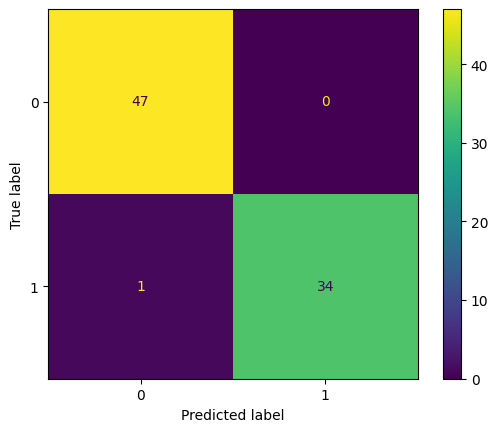

In [10]:
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(clf, X_test_scaled, y_test)
plt.show()

##  Sauvegarde du modèle

In [11]:
joblib.dump(clf, "modele_entraine.joblib")
joblib.dump(scaler, "scaler.joblib")
files.download("modele_entraine.joblib")
files.download("scaler.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>